In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
df = pd.read_csv('./housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
X = df[['RM']].values
y = df[['MEDV']].values
scx = StandardScaler()
scy = StandardScaler()
X_train = scx.fit_transform(X)
y_train = scy.fit_transform(y)
print(X_train.shape)
print(y_train.shape)

(506, 1)
(506, 1)


In [4]:
import numpy as np
import sys
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0., epochs=200, eta=0.001, shuffle=True, minibatch_size=1, seed=None, drop_out = False):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.drop_out = drop_out
  
    def _Relu(self, z):
        return np.maximum(0, z)

    def _dropout(self, X):

        a = np.random.randint(2, size = X.shape)    
        while np.array_equal(X, np.zeros(shape=X.shape)):
          a = np.random.randint(2, shape = X.shape)
        return a*X

    def _forward(self, X):        
        if self.drop_out:
            X = self._dropout(X)
        z_h = np.dot(X, self.w_h) + self.b_h
        
        a_h = self._Relu(z_h)

        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._Relu(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        cost = np.sum((y_enc - output)**2)
        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        return a_out
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = 1 # no. of class labels
        n_features = X_train.shape[1]
        ########################
        # Weight initialization
        ########################
        
        self.b_h = np.zeros(self.n_hidden)
      
        #initializer 
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)

        #initializer 
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_output))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
      
        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
              self.random.shuffle(indices)
            for start_idx in range(0,indices.shape[0] -self.minibatch_size +1,self.minibatch_size):
                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                ##################
                # Backpropagation
                ##################
                
                sigma_out = a_out - y_train[batch_idx]
                relu_derivative_h = np.zeros(len(a_h[0]))
                       
                for i in range(len(a_h[0])):
                    if a_h[0][i] > 0:
                        relu_derivative_h[i] = 1
                    else:
                        relu_derivative_h[i] = 0
                
                sigma_h = (np.dot(sigma_out, self.w_out.T)*relu_derivative_h)
                
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                # Regularization and weight updates
                delta_w_h = grad_w_h
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = grad_w_out
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            #############
            # Evaluation
            #############
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
        
            cost = self._compute_cost(y_train,a_out)
            self.eval_['cost'].append(cost)
            #print('cost:', self.eval_['cost'][len(self.eval_['cost'])-1], end = ',')
        return self

In [5]:
nn = NeuralNetMLP()
nn.n_hidden=30
nn.epochs = 300
nn.dropout = True
nn.eta = 0.00001
nn.fit(X_train = X_train[:500], y_train = y_train[:500], X_valid = X_train[500:], y_valid = y_train[500:])

In [6]:
y_pred = nn.predict(X_train)

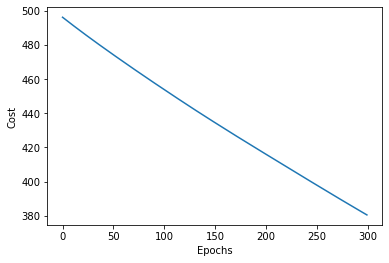

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
if nn.dropout == True:
    plt.savefig('cost_vs_epoch_with_Dropout.png')
elif nn.dropout == False:
    plt.savefig('cost_vs_epoch.png')
plt.show()

In [8]:
np.min(nn.eval_['cost'])

380.5486193269093

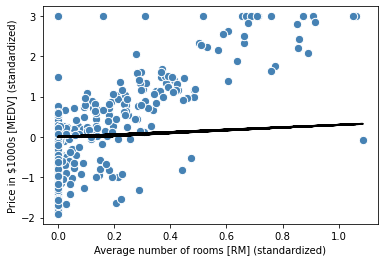

In [9]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None
lin_regplot(y_pred, y_train, nn)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
if nn.dropout == True:
    plt.savefig('predictdo.png')
elif nn.dropout == False:
    plt.savefig('predict.png')
plt.show()